### Introduction ###

I'm looking for a masters program, since I spent 2 years at Cornell for B.S. and enjoyed the times in Ithaca, it would be a good idea to find a college with similar location settings. However, there were no good bakery in Ithaca, none at all, so i had ended up learning how to make pastries myself, and it became a pet peeve: I need a high quality bakery near where i live or work. Cost of living is another factor. Taking a loan for both the tuition and the living expanses adds up quickly, Even though a college town might drive the prices up, but there's still a big difference between Ithaca and Manhattan.
So in general, the criteria to find the best college location are:
1. High density of outdoor recreation areas: i.e. parks/ forests/ lakes
2. Similar to the venue setting to Ithaca, NY, excluding No.1
3. Reasonable cost of living, the lower the better

### Data Description ###

I selected a list of 10 potential colleges that I want to apply, get their locations with google map api, Pull the top 100 venue within 4.5km radius from Foursquare, isolate the 'trail' venues since i recently picked up on hiking. Then I analyze the similarities between ithaca and other areas' categories with clustering. 
I also included the cost of living data from areavibes as it will be an important factor in the final decision.

### Methodology ###
I added comments throughout the coding cells to explain what was done

In [1]:
!pip install googlemaps

In [2]:
# Import modules and create the base set for college selection
import pandas as pd
import googlemaps
import requests
df_CollegeSelection=pd.DataFrame({
    'College':['University of Illinois at Urbana-Champaign',
    'University of California, Berkeley',
    'University of Chicago',
    'Cornell University' ,
    'University of Pennsylvania',
    'New York University',
    'Georgia Institute of Technology',
    'University of Southern California',
    'Massachusetts Institute of Technology',
    'Johns Hopkins University']
    })
df_CollegeSelection

,College
0,University of Illinois at Urbana-Champaign
1,"University of California, Berkeley"
2,University of Chicago
3,Cornell University
4,University of Pennsylvania
5,New York University
6,Georgia Institute of Technology
7,University of Southern California
8,Massachusetts Institute of Technology
9,Johns Hopkins University


In [3]:
!pip install geopy
from geopy.geocoders import Nominatim

In [4]:
list=['University of Illinois',
    'University of Chicago',
    'Cornell University' ,
    'University of Pennsylvania',
    'New York University',
    'Georgia Institute of Technology',
    'University of Southern California',
    'Massachusetts Institute of Technology',
    'Johns Hopkins University']

In [5]:
# The cost of living was manually searched from areavibes.com which takes data from coli.org by C2ER 
cost_of_living = [92, 110, 104, 102,  162, 108, 148, 172, 100]
cost_of_living = pd.DataFrame(cost_of_living)
cost_of_living = cost_of_living.rename(columns={ cost_of_living.columns[0]: "Cost_of_living" })

In [6]:
geolocator = Nominatim(user_agent="College Locations")

In [7]:
#append the geolocation data to the DF
location = []
latitude = []
longitude = []
for i in range(len(list)):
  location.append(geolocator.geocode(list[i]))
  latitude.append(location[i].latitude)
  longitude.append(location[i].longitude)

In [8]:
df1 = pd.DataFrame(list)
df1 = df1.rename(columns={ df1.columns[0]: "college" })
latitude = pd.DataFrame(latitude)
latitude = latitude.rename(columns={ latitude.columns[0]: "latitude" })
longitude = pd.DataFrame(longitude)
longitude = longitude.rename(columns={ longitude.columns[0]: "longitude" })
df = pd.concat([df1, latitude, longitude, cost_of_living], axis=1)
df = df.rename(columns={ df.columns[0]: "college" })
df

,college,latitude,longitude,Cost_of_living
0,University of Illinois,40.141058,-88.255202,92
1,University of Chicago,41.785447,-87.593879,110
2,Cornell University,42.450551,-76.478351,104
3,University of Pennsylvania,39.949338,-75.189644,102
4,New York University,40.729253,-73.996254,162
5,Georgia Institute of Technology,33.776033,-84.398841,108
6,University of Southern California,34.021883,-118.285867,148
7,Massachusetts Institute of Technology,42.358396,-71.095678,172
8,Johns Hopkins University,39.330202,-76.621868,100


In [9]:
# assign label for its range of price
def label_price(price):
  if 90 < price <= 100:
    return 'LOW'
  elif  100 < price <= 140:
    return 'MEDIUM'
  elif  140 < price <= 200:
    return 'HIGH'
  elif  price > 300:
    return 'EXTREME'
  else:
    return 'Your price can not be negative'

# create another column in the data
df['price_label'] = df['Cost_of_living'].apply(label_price)
df

,college,latitude,longitude,Cost_of_living,price_label
0,University of Illinois,40.141058,-88.255202,92,LOW
1,University of Chicago,41.785447,-87.593879,110,MEDIUM
2,Cornell University,42.450551,-76.478351,104,MEDIUM
3,University of Pennsylvania,39.949338,-75.189644,102,MEDIUM
4,New York University,40.729253,-73.996254,162,HIGH
5,Georgia Institute of Technology,33.776033,-84.398841,108,MEDIUM
6,University of Southern California,34.021883,-118.285867,148,HIGH
7,Massachusetts Institute of Technology,42.358396,-71.095678,172,HIGH
8,Johns Hopkins University,39.330202,-76.621868,100,LOW


In [10]:
CLIENT_ID = 'HSCM0EZ2Z5MMRBN1DAEDEZODLAS2LT141V5H2421CDETYLYK'
CLIENT_SECRET = '11MPDDWUQQU1YW3PYEL2MRZ35L2BSVBLHAFBW5SGRPWVJJKC'
VERSION = '20180604'
# define function to get all nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=45000, limit=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['college', 
                  'college Latitude', 
                  'college Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
# get venues from center of each college

college_venues = getNearbyVenues(names=df.iloc[:,0],
                              latitudes=df.iloc[:,1],
                              longitudes=df.iloc[:,2]
                             )

University of Illinois
University of Chicago
Cornell University
University of Pennsylvania
New York University
Georgia Institute of Technology
University of Southern California
Massachusetts Institute of Technology
Johns Hopkins University


In [14]:
print(college_venues.shape)
college_venues.head()

(900, 7)


,college,college Latitude,college Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,University of Illinois,40.141058,-88.255202,Binny's Beverage Depot,40.143400,-88.256831,Liquor Store
1,University of Illinois,40.141058,-88.255202,Virginia Theatre,40.116932,-88.245392,Music Venue
2,University of Illinois,40.141058,-88.255202,Black Dog Smoke & Ale House,40.117919,-88.240252,BBQ Joint
3,University of Illinois,40.141058,-88.255202,The Blind Pig,40.117032,-88.242312,Pub
4,University of Illinois,40.141058,-88.255202,Jarling’s,40.097763,-88.247707,Ice Cream Shop


In [15]:
# Extract the number of trails and append to DF
trails_college=college_venues.copy()
trails_college['Venue Category']=trails_college['Venue Category'].mask(trails_college['Venue Category'].ne('Trail'))
trails=trails_college.groupby('college')['Venue Category'].count().tolist()
trails=pd.DataFrame(trails)
df=pd.concat([df,trails],axis=1)
df=df.rename(columns={0:'Trails'})
df.head()


,college,latitude,longitude,Cost_of_living,price_label,Trails
0,University of Illinois,40.141058,-88.255202,92,LOW,3
1,University of Chicago,41.785447,-87.593879,110,MEDIUM,10
2,Cornell University,42.450551,-76.478351,104,MEDIUM,0
3,University of Pennsylvania,39.949338,-75.189644,102,MEDIUM,2
4,New York University,40.729253,-73.996254,162,HIGH,1


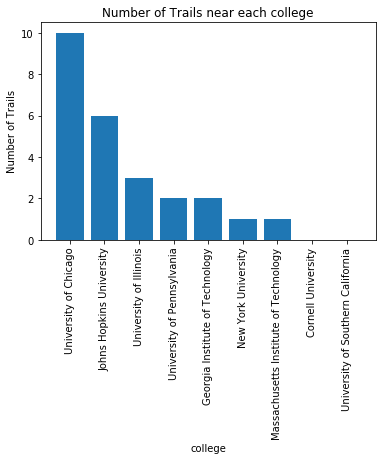

In [31]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# plot number of trails near each college
df_trail_Plot=df
df_trail_Plot.sort_values('Trails', ascending = False, inplace = True)
plt.bar(df_trail_Plot['college'], df_trail_Plot['Trails'])
plt.title('Number of Trails near each college')
plt.xticks(rotation=90)
plt.xlabel('college')
plt.ylabel('Number of Trails')
plt.show()

In [17]:
# Count the unique number of venue categories near all colleges
num_unique_venue = college_venues['Venue Category'].unique()
print(num_unique_venue)
print('There are: {} unique venues in all districts'.format(len(num_unique_venue)))

['Liquor Store' 'Music Venue' 'BBQ Joint' 'Pub' 'Ice Cream Shop'
 'Sushi Restaurant' 'Mexican Restaurant' 'Park' 'Coffee Shop'
 'Breakfast Spot' 'Grocery Store' 'Burger Joint' 'Organic Grocery' 'Spa'
 'American Restaurant' 'Performing Arts Venue' 'Cosmetics Shop'
 'Sporting Goods Shop' 'Restaurant' 'Bookstore' 'Chinese Restaurant'
 'Record Shop' 'Italian Restaurant' 'Indie Movie Theater' 'Farmers Market'
 'Brewery' 'Video Game Store' 'Pizza Place' 'Bakery' 'Bar' 'Market'
 'Gym / Fitness Center' 'Farm' 'Athletics & Sports' 'Sports Bar'
 'Fried Chicken Joint' 'Big Box Store' 'Fast Food Restaurant'
 'College Basketball Court' 'Supermarket' 'Food Truck' 'Garden Center'
 'Fabric Shop' 'Warehouse Store' 'Bowling Alley' 'Movie Theater'
 'Pet Store' 'Convenience Store' 'Pharmacy' 'Beer Bar' 'Bank' 'Lake'
 'Department Store' 'Automotive Shop' 'Tex-Mex Restaurant' 'Hotel'
 'Science Museum' 'History Museum' 'African Restaurant' 'Art Gallery'
 'Waterfront' 'Rock Club' 'Other Great Outdoors' 'Art M

In [18]:
# find the unique venue categories near each college
num_venue_category = (college_venues.groupby(['college','Venue Category'])
                              .count().reset_index()[['college','Venue Category']].groupby('college')
                                  .count().reset_index() )
num_venue_category

,college,Venue Category
0,Cornell University,59
1,Georgia Institute of Technology,55
2,Johns Hopkins University,54
3,Massachusetts Institute of Technology,55
4,New York University,58
5,University of Chicago,62
6,University of Illinois,56
7,University of Pennsylvania,56
8,University of Southern California,59


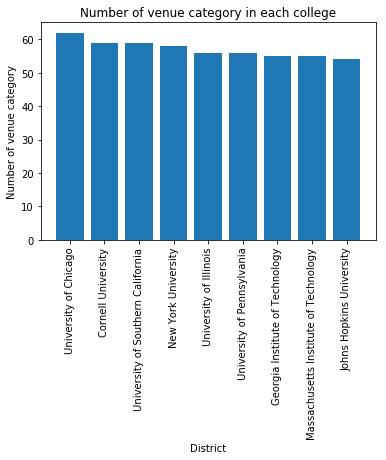

In [19]:
# plot the number of venue category near each college
num_venue_category.sort_values('Venue Category', ascending = False, inplace = True)
plt.bar(num_venue_category['college'], num_venue_category['Venue Category'])
plt.title('Number of venue category in each college')
plt.xticks(rotation=90)
plt.xlabel('District')
plt.ylabel('Number of venue category')
plt.show()



In [20]:
# one hot encoding using pandas dummies
college_onehot = pd.get_dummies(college_venues[['Venue Category']], prefix="", prefix_sep="")

#add name of college column to dataframe
college_onehot['college'] = college_venues['college'] 

#group according to college and then mean() according to features (each category) to find the frequency of each category near each college
college_grouped = college_onehot.groupby('college').mean().reset_index()
college_grouped

,college,African Restaurant,American Restaurant,Amphitheater,Aquarium,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Vineyard,Volleyball Court,Warehouse Store,Waterfall,Waterfront,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo
0,Cornell University,0.00,0.08,0.00,0.00,0.00,0.01,0.01,0.00,0.00,...,0.02,0.00,0.01,0.02,0.00,0.00,0.03,0.01,0.00,0.00
1,Georgia Institute of Technology,0.00,0.03,0.00,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00
2,Johns Hopkins University,0.00,0.04,0.00,0.01,0.00,0.03,0.01,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00
3,Massachusetts Institute of Technology,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.00,0.00,0.00
4,New York University,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,...,0.00,0.01,0.00,0.00,0.00,0.00,0.02,0.00,0.02,0.00
5,University of Chicago,0.01,0.00,0.01,0.00,0.01,0.01,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.00
6,University of Illinois,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.01,0.01,...,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,University of Pennsylvania,0.00,0.02,0.00,0.00,0.00,0.02,0.01,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.01
8,University of Southern California,0.00,0.02,0.00,0.00,0.00,0.01,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.01,0.03,0.00,0.01,0.00


In [21]:
import numpy as np
# return most common venues in each district
def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# show (say: 10 most common venues in each district)
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['college']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
college_venues_sorted = pd.DataFrame(columns=columns)
college_venues_sorted['college'] = college_grouped['college']

for ind in np.arange(college_grouped.shape[0]):
    college_venues_sorted.iloc[ind, 1:] = most_common_venues(college_grouped.iloc[ind, :], num_top_venues)

college_venues_sorted

,college,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cornell University,American Restaurant,Ice Cream Shop,Coffee Shop,Park,Brewery,Wine Shop,State / Provincial Park,Hotel,Trail,Bakery
1,Georgia Institute of Technology,Trail,Park,Brewery,Grocery Store,Pizza Place,BBQ Joint,Steakhouse,Liquor Store,Ice Cream Shop,Mexican Restaurant
2,Johns Hopkins University,Park,Seafood Restaurant,American Restaurant,Liquor Store,Ice Cream Shop,Coffee Shop,Italian Restaurant,Mexican Restaurant,Gym,Art Museum
3,Massachusetts Institute of Technology,Bakery,Park,Seafood Restaurant,Mexican Restaurant,Sandwich Place,Brewery,Gastropub,Ice Cream Shop,Bookstore,Pizza Place
4,New York University,Park,Bookstore,Pier,Theater,Scenic Lookout,Bakery,Ice Cream Shop,Restaurant,Yoga Studio,Plaza
5,University of Chicago,Hotel,Park,Ice Cream Shop,Liquor Store,Theater,Coffee Shop,Grocery Store,Yoga Studio,Brewery,Tour Provider
6,University of Illinois,Mexican Restaurant,Coffee Shop,Chinese Restaurant,Park,American Restaurant,Bar,Fast Food Restaurant,BBQ Joint,Ice Cream Shop,Burger Joint
7,University of Pennsylvania,Park,Coffee Shop,Bar,Brewery,Deli / Bodega,Gastropub,Wine Bar,Café,Concert Hall,Israeli Restaurant
8,University of Southern California,Coffee Shop,Hotel,Trail,Park,Ice Cream Shop,Italian Restaurant,Pizza Place,Wine Shop,Sandwich Place,Scenic Lookout


In [22]:
#Choose only columns with Restaurant
column_named_Restaurant = college_grouped.columns
column_name = [venue_category for venue_category in column_named_Restaurant if 'Restaurant' in venue_category]
data_Restaurant = college_grouped[['college']+column_name]
data_Restaurant

,college,African Restaurant,American Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Comfort Food Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,...,Seafood Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Cornell University,0.00,0.08,0.01,0.00,0.00,0.00,0.00,0.00,0.01,...,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.01,0.01
1,Georgia Institute of Technology,0.00,0.03,0.00,0.01,0.00,0.00,0.00,0.00,0.00,...,0.01,0.02,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00
2,Johns Hopkins University,0.00,0.04,0.01,0.00,0.00,0.00,0.00,0.01,0.02,...,0.06,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,Massachusetts Institute of Technology,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,...,0.05,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.00
4,New York University,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00
5,University of Chicago,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,University of Illinois,0.00,0.04,0.00,0.00,0.05,0.00,0.00,0.00,0.04,...,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.00,0.00,0.00
7,University of Pennsylvania,0.00,0.02,0.01,0.00,0.00,0.01,0.01,0.00,0.00,...,0.02,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.02
8,University of Southern California,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00


In [23]:
# show (say: 10 most common Restaurants near each college)
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create column according to number of top venues
column = ['college']
for ind in np.arange(num_top_venues):
    try:
        column.append('{}{} Most Restaurant'.format(ind+1, indicators[ind]))
    except:
        column.append('{}th Most Restaurant'.format(ind+1))

# create a new dataframe
Restaurant_sorted = pd.DataFrame(columns=column)
Restaurant_sorted['college'] = data_Restaurant['college']

for ind in np.arange(data_Restaurant.shape[0]):
    Restaurant_sorted.iloc[ind, 1:] = most_common_venues(data_Restaurant.iloc[ind, :], num_top_venues)

Restaurant_sorted

,college,1st Most Restaurant,2nd Most Restaurant,3rd Most Restaurant,4th Most Restaurant,5th Most Restaurant,6th Most Restaurant,7th Most Restaurant,8th Most Restaurant,9th Most Restaurant,10th Most Restaurant
0,Cornell University,American Restaurant,Mexican Restaurant,Vietnamese Restaurant,Seafood Restaurant,Korean Restaurant,Latin American Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Restaurant,New American Restaurant
1,Georgia Institute of Technology,American Restaurant,Mexican Restaurant,Southern / Soul Food Restaurant,Italian Restaurant,Mediterranean Restaurant,French Restaurant,Thai Restaurant,Tapas Restaurant,Brazilian Restaurant,Seafood Restaurant
2,Johns Hopkins University,Seafood Restaurant,American Restaurant,Italian Restaurant,Mexican Restaurant,Fast Food Restaurant,Latin American Restaurant,Spanish Restaurant,Mediterranean Restaurant,Falafel Restaurant,Portuguese Restaurant
3,Massachusetts Institute of Technology,Mexican Restaurant,Seafood Restaurant,Italian Restaurant,Tapas Restaurant,Japanese Restaurant,French Restaurant,Jewish Restaurant,Greek Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant
4,New York University,Thai Restaurant,Restaurant,Moroccan Restaurant,Italian Restaurant,French Restaurant,Seafood Restaurant,New American Restaurant,Vietnamese Restaurant,Israeli Restaurant,Indian Restaurant
5,University of Chicago,Seafood Restaurant,Italian Restaurant,New American Restaurant,African Restaurant,Mediterranean Restaurant,Molecular Gastronomy Restaurant,French Restaurant,Japanese Restaurant,Falafel Restaurant,English Restaurant
6,University of Illinois,Mexican Restaurant,Chinese Restaurant,American Restaurant,Fast Food Restaurant,Restaurant,Sushi Restaurant,Tex-Mex Restaurant,Italian Restaurant,French Restaurant,Israeli Restaurant
7,University of Pennsylvania,Vietnamese Restaurant,American Restaurant,Israeli Restaurant,Seafood Restaurant,New American Restaurant,Mexican Restaurant,Asian Restaurant,Comfort Food Restaurant,English Restaurant,French Restaurant
8,University of Southern California,Italian Restaurant,American Restaurant,Sushi Restaurant,Mediterranean Restaurant,Korean Restaurant,German Restaurant,Latin American Restaurant,Taiwanese Restaurant,Japanese Restaurant,New American Restaurant


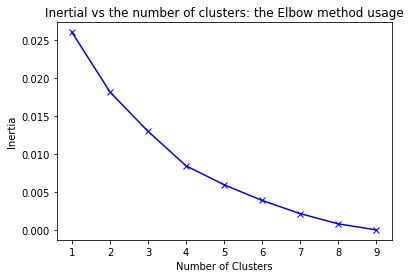

In [24]:
# import k-means for clustering the district to find the pattern
from sklearn.cluster import KMeans
# try with 10 different values of k to find the best one
number_clustering = 10
Inertia = []

college_Restaurant = data_Restaurant.drop('college', axis = 1)

for idx in range(1, number_clustering):

    # run k-means clustering
    kmeans = KMeans(n_clusters=idx, random_state=0).fit(college_Restaurant)

    # find the distortion w.r.t each k
    Inertia.append(kmeans.inertia_)

plt.plot(range(1, number_clustering), Inertia, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertial vs the number of clusters: the Elbow method usage')
plt.show()

In [25]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters).fit(college_Restaurant)

In [26]:
# merge the data with the cluster obtained
data_summary = pd.DataFrame(zip(data_Restaurant['college'], kmeans.labels_), columns=['college','label'])
data_combined_summary = pd.merge(data_summary, df, left_on = 'college', right_on = 'college', how='left')
data_combined_summary

,college,label,latitude,longitude,Cost_of_living,price_label,Trails
0,Cornell University,2,42.450551,-76.478351,104,MEDIUM,0
1,Georgia Institute of Technology,0,33.776033,-84.398841,108,MEDIUM,2
2,Johns Hopkins University,1,39.330202,-76.621868,100,LOW,6
3,Massachusetts Institute of Technology,1,42.358396,-71.095678,172,HIGH,1
4,New York University,0,40.729253,-73.996254,162,HIGH,1
5,University of Chicago,0,41.785447,-87.593879,110,MEDIUM,10
6,University of Illinois,2,40.141058,-88.255202,92,LOW,3
7,University of Pennsylvania,0,39.949338,-75.189644,102,MEDIUM,2
8,University of Southern California,0,34.021883,-118.285867,148,HIGH,0


### Results ###
First I took the number of trails from Foursquare, and u Chicago suprising came out on top with 10 trails nearby. 
The total unique venues did not differ by much across the colleges. 

After using K-means clustering with k=3, we select 1 out of each cluster based on cost of living as it is our main concern. 
Then we normalized the data with the ratio of 5:3:2, cost_of_living:trails:restaurants, and the highest score was U Illinois.

In [27]:
# sum the data_restaurant along the row
data_combined_summary['restaurant_frequency'] = data_Restaurant.sum(axis=1)
data_combined_summary.sort_values('label').reset_index(drop=True)

,college,label,latitude,longitude,Cost_of_living,price_label,Trails,restaurant_frequency
0,Georgia Institute of Technology,0,33.776033,-84.398841,108,MEDIUM,2,0.19
1,New York University,0,40.729253,-73.996254,162,HIGH,1,0.09
2,University of Chicago,0,41.785447,-87.593879,110,MEDIUM,10,0.11
3,University of Pennsylvania,0,39.949338,-75.189644,102,MEDIUM,2,0.22
4,University of Southern California,0,34.021883,-118.285867,148,HIGH,0,0.17
5,Johns Hopkins University,1,39.330202,-76.621868,100,LOW,6,0.28
6,Massachusetts Institute of Technology,1,42.358396,-71.095678,172,HIGH,1,0.24
7,Cornell University,2,42.450551,-76.478351,104,MEDIUM,0,0.21
8,University of Illinois,2,40.141058,-88.255202,92,LOW,3,0.26


In [28]:
df_selection=data_combined_summary.loc[[2,6,7],['college','Cost_of_living','Trails','restaurant_frequency']].reset_index(drop=True)

df_sl=df_selection.set_index('college')
df_sl

,Cost_of_living,Trails,restaurant_frequency
college,,,
Johns Hopkins University,100,6,0.28
University of Illinois,92,3,0.26
University of Pennsylvania,102,2,0.22


In [29]:
# use sklearn standard scaler to normalize the data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
x = df_sl.values 
StandardScaler = preprocessing.StandardScaler()
x_scaled = StandardScaler.fit_transform(x)
df_normalized = pd.DataFrame(x_scaled).rename({0:'Johns Hopkins University',1:'University of Illinois',2:'University of Pennsylvania'})
df_normalized.columns=['Col','Trail',"Food"]
df_normalized

,Col,Trail,Food
Johns Hopkins University,0.46291,1.372813,1.069045
University of Illinois,-1.38873,-0.392232,0.267261
University of Pennsylvania,0.92582,-0.980581,-1.336306


In [30]:
for t,row in df_normalized.iterrows():
    df_normalized.loc[t,'Score'] = row['Col']*(-5)+row['Trail']*3+row['Food']*2
df_normalized

,Col,Trail,Food,Score
Johns Hopkins University,0.46291,1.372813,1.069045,3.941979
University of Illinois,-1.38873,-0.392232,0.267261,6.301476
University of Pennsylvania,0.92582,-0.980581,-1.336306,-10.243455


### Discussion ### 
I initially forgot about this project and revisited it a couple month later, so it looks really basic but i gave all of my effort. It sheds some insight in the over simplified college selection process, and right now obviously I will turn to online MS. 
The cost of living data was hard to find, since not smaller cities were not included on Numbeo, I had to manually search each one online. The cost of living index is an estimate of the average costs of essentials like food and housing, and there are many brilliant datasets that contain details like milk/bread price, average rent, bus tickets, and utilities, and i would love to include those if this project expands to something more concrete. 

The bulk part of this project was collecting data from foursquare and analyize with some basic techniques that i learned in this course. The clustering result assigned u illinois similar to ithaca, and it was only based on venue-categories, in reality however, i suppose all college towns have a familiar vibe: blooming with stressed out students during academic months, and dead silent during summer breaks. i was not sure about the last normalization process, whether i used the correct function, I also explored minmaxscaler, and normalize, but none gave me the results i wanted. The ratio is arbitrary though it emphasizes the cost of living, there's probably a better way to analyze all 10 colleges for the 3 criteria. 


### Conclusion ###
This simple analysis showed that U illinois was a good fit based on cost of living, and my leisure activities, eating and then go hiking. Though the cost of living data indicated Illinois is the lowest amoung the selected colleges, in reality, things are still pretty expansive the closer you get to the campus. Despite it only has a medium level of venue diversity, the amount of coffee shops really highlighted the vibes of the city. 
